## **📊 Project Structure: Sales Analysis & Forecasting**

## 📌 **Project Overview**
This project focuses on analyzing historical sales data and building forecasting models to predict future sales trends.  
The goal is to extract insights that help businesses in:  
- **Inventory Planning**  
- **Revenue Forecasting**  
- **Customer & Product Insights**  
- **Strategic Decision Making**

## 1. **Introduction**

* Business context: why sales forecasting is important (inventory, revenue planning).
* Objective: analyze past sales & forecast future sales.

---

## 2. **Data Understanding**

* Show first few rows of dataset.
* Mention key columns (`Order Date`, `Sales`, `Category`, `Region`, etc.).
* Quick stats: number of rows, time period covered, unique customers/products.

---

## 3. **Data Preprocessing**

* Handle missing values, duplicates.
* Convert `Order Date` to datetime.
* Aggregate daily → monthly sales.
* Feature engineering: Month, Year, Region, Category, etc.

---

## 4. **Exploratory Data Analysis (EDA)**

  Include rich visualizations here:

* **Overall Sales Trend** (line plot).
* **Sales by Category/Sub-Category** (bar plot).
* **Sales by Region/State** (map/heatmap).
* **Sales by Customer Segment** (bar plot).
* **Pareto Chart (80/20)** for products/customers.
* **Seasonality Heatmap** (Year vs Month).
* **Top 10 Products** by sales.

---

## 5. **Time Series Analysis**

* Seasonal decomposition (trend, seasonal, residual).
* Stationarity check (ADF test).

---

## 6. **Forecasting Models**

* **Baseline Forecasts** (naive, moving average).
* **ARIMA / Auto-ARIMA** -  forecast + confidence bands.
* **RandomForest & GradientBoosting** with lag features.
* **Comparison of Models** (train vs test predictions).

---

## 7. **Model Evaluation**

👉 Include both numbers + visuals:

* Metrics: MAE, RMSE for each model.
* Plot: Actual vs Predicted for each model.
* **Residual Diagnostics** (histogram of errors, time plot, ACF/PACF).

---

## 8. **Future Forecasting**

* Show **12-month ahead forecast** with confidence intervals.
* Compare forecasts from ARIMA vs ML models.

---

## 9. **Insights & Recommendations**

* Seasonality insights (e.g., peak sales months).
* Category/region performance (which contributes most).
* Customer behavior (loyal vs one-time buyers).
* Recommendations for business (stock management, targeted marketing).

---

## 10. **Conclusion**

* Summarize what was done (EDA, models, forecasting).
* Key business takeaway: e.g., *“Electronics and Furniture dominate sales; North region grows fastest; forecast shows a 10% growth next year.”*

In [2]:
# Install required packages
!pip install -q pmdarima plotly scikit-learn statsmodels openpyxl
!pip install -q prophet
!pip install numpy==1.26.4
!pip install pmdarima
!pip install plotly

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import pmdarima as pm
import warnings, io
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)

In [7]:
# upload CSV
from google.colab import files

print("Upload a CSV file")
uploaded = files.upload()

if uploaded:
    fname = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[fname]))
    # detect date-like column
    date_cols = [c for c in df.columns if 'date' in c.lower() or 'day' in c.lower()]
    sales_cols = [c for c in df.columns if any(x in c.lower() for x in ['sale','sales','revenue','amount'])]
    if len(date_cols)==0:
        raise ValueError("No date-like column found. Make sure your CSV has a date column (e.g., 'date').")
    date_col = date_cols[0]
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True)
    df = df.sort_values(date_col)
    df = df.rename(columns={date_col:'date'})
    if len(sales_cols)==0:
        # fallback: pick first non-date column as sales
        sales_col = [c for c in df.columns if c!='date'][0]
        print(f"No obvious sales column found. Using '{sales_col}' as sales.")
    else:
        sales_col = sales_cols[0]
    df = df.rename(columns={sales_col:'sales'})[['date','sales']]
    print("Sample rows:")
    display(df.head(10))

Upload a CSV file


Saving train.csv to train (4).csv
Sample rows:


,date,sales
7980,2015-01-03,16.448
741,2015-01-04,3.540
740,2015-01-04,272.736
739,2015-01-04,11.784
1759,2015-01-05,19.536
7478,2015-01-06,755.960
7477,2015-01-06,391.980
5327,2015-01-06,19.440
7474,2015-01-06,2573.820
7480,2015-01-06,6.540


In [8]:
# preprocessing and aggregation to monthly series
df['date'] = pd.to_datetime(df['date'])
df = df.groupby('date', as_index=False)['sales'].sum()   # aggregate duplicate dates
df = df.sort_values('date').set_index('date')

# Aggregate to monthly (month-start). This works whether your input is daily/weekly/monthly.
ts = df['sales'].resample('MS').sum()

print(f"Time series range: {ts.index.min().date()} to {ts.index.max().date()} ({len(ts)} points)")
display(ts.head(10))

Time series range: 2015-01-01 to 2018-12-01 (48 points)


,sales
date,
2015-01-01,14205.7070
2015-02-01,4519.8920
2015-03-01,55205.7970
2015-04-01,27906.8550
2015-05-01,23644.3030
2015-06-01,34322.9356
2015-07-01,33781.5430
2015-08-01,27117.5365
2015-09-01,81623.5268


In [9]:
# EDA plots
fig = px.line(x=ts.index, y=ts.values, labels={'x':'date','y':'sales'}, title='Monthly Sales (interactive)')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

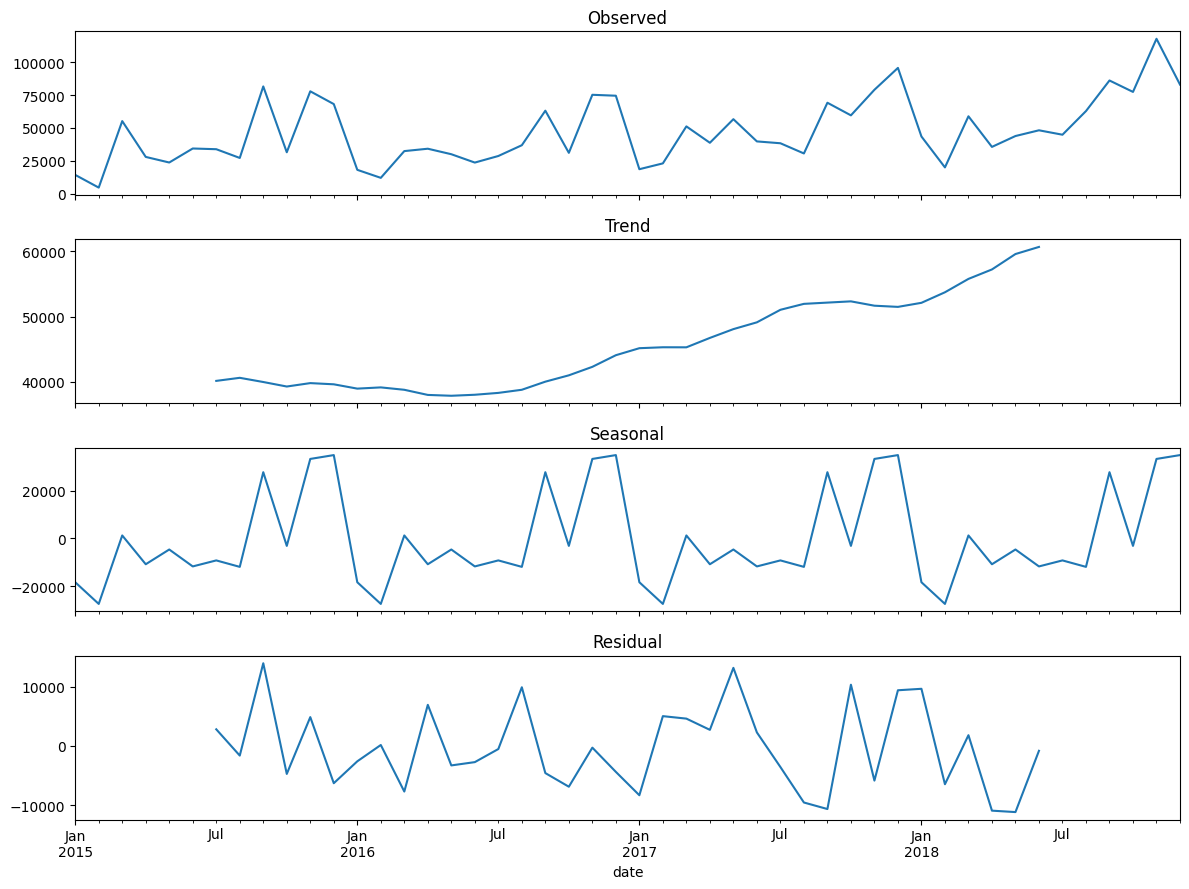

In [10]:
# Seasonal decomposition if enough points
if len(ts) >= 24:
    decomposition = seasonal_decompose(ts, model='additive', period=12)
    fig, axes = plt.subplots(4,1, figsize=(12,9), sharex=True)
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for seasonal decomposition (need >=24 points).")

In [11]:
# choose horizon h and split into train/test
n = len(ts)
if n >= 36:
    h = 12
elif n >= 24:
    h = 6
else:
    h = max(3, int(n*0.2))

train = ts.iloc[:-h].copy()
test  = ts.iloc[-h:].copy()

print(f"Total points: {n}. Forecast horizon h={h}. Train: {len(train)} points. Test: {len(test)} points.")

Total points: 48. Forecast horizon h=12. Train: 36 points. Test: 12 points.


In [12]:
# baseline forecasts and metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE manually for compatibility
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # safe MAPE: ignore zero true values
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))*100 if mask.any() else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE%': mape}

# Naive forecast: repeat last observed value
naive_pred = np.repeat(train.iloc[-1], h)

# Seasonal naive (repeat last 12 months pattern) if possible
if len(train) >= 12:
    last12 = train.iloc[-12:].values
    seasonal_naive = np.tile(last12, int(np.ceil(h/12)))[:h]
else:
    seasonal_naive = naive_pred

# Moving average (window 3 months)
ma3 = [train.rolling(3).mean().iloc[-1]] * h

baselines = {'Naive': naive_pred, 'SeasonalNaive': seasonal_naive, 'MA3': ma3}

for name, pred in baselines.items():
    print(name, evaluate(test.values, pred))

Naive {'MAE': 39267.958399999996, 'RMSE': 43945.62352716607, 'MAPE%': 98.7295365777547}
SeasonalNaive {'MAE': 15444.17785, 'RMSE': 18932.101375680024, 'MAPE%': 24.86466920943577}
MA3 {'MAE': 26747.345333333342, 'RMSE': 31442.58525915809, 'MAPE%': 67.77808595832035}


In [13]:
# Auto ARIMA with pmdarima
m = 12 if len(train) >= 24 else 1
seasonal = True if m > 1 else False
print(f"AutoARIMA parameters -> seasonal={seasonal}, m={m}")

# Fit
model = pm.auto_arima(train,
                      start_p=0, start_q=0,
                      max_p=5, max_q=5,
                      seasonal=seasonal, m=m,
                      stepwise=True, suppress_warnings=True,
                      error_action='ignore', trace=False)

# model.order() sometimes returns the (p,d,q) tuple — robust access:
try:
    sel_order = model.order()
except Exception:
    sel_order = getattr(model, 'order', None)

print("Selected ARIMA order:", sel_order)

# Forecast for test horizon
fcast = model.predict(n_periods=h)
index_forecast = pd.date_range(start=test.index[0], periods=h, freq='MS')
arima_pred = pd.Series(fcast, index=index_forecast)

print("ARIMA on test:", evaluate(test.values, arima_pred.values))

AutoARIMA parameters -> seasonal=True, m=12
Selected ARIMA order: (1, 0, 0)
ARIMA on test: {'MAE': 17909.757121398103, 'RMSE': 23731.971025095896, 'MAPE%': 29.997587539339914}


In [14]:
# plot train, test, and arima forecast (interactive)
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train.values, name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test.values, name='Test', mode='markers+lines'))
fig.add_trace(go.Scatter(x=index_forecast, y=arima_pred.values, name='ARIMA Forecast', mode='lines'))

# add naive baseline for comparison
fig.add_trace(go.Scatter(x=index_forecast, y=naive_pred, name='Naive', line=dict(dash='dash')))
fig.update_layout(title='Actual vs Forecast', xaxis_title='Date', yaxis_title='Sales', xaxis_rangeslider_visible=True)
fig.show()

In [15]:
# compare model metrics and save forecasts
results = []
# baselines
for name, pred in baselines.items():
    results.append({'model': name, **evaluate(test.values, pred)})
# ARIMA
results.append({'model':'ARIMA', **evaluate(test.values, arima_pred.values)})

results_df = pd.DataFrame(results).set_index('model')
display(results_df)

# Save ARIMA future forecast (next 'future_steps' months after last available date)
future_steps = 12
future_pred = model.predict(n_periods=future_steps)
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_series = pd.Series(future_pred, index=future_index)
future_series.to_csv('future_forecast_arima.csv', header=['forecast'])
print("Saved future forecast to future_forecast_arima.csv")

# Download (Colab)
from google.colab import files
files.download('future_forecast_arima.csv')

,MAE,RMSE,MAPE%
model,,,
Naive,39267.958400,43945.623527,98.729537
SeasonalNaive,15444.177850,18932.101376,24.864669
MA3,26747.345333,31442.585259,67.778086
ARIMA,17909.757121,23731.971025,29.997588


Saved future forecast to future_forecast_arima.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# feature engineering for ML: create lag features and rolling features
def create_lag_features(series, lags=[1,2,3,6,12]):
    df_feat = pd.DataFrame({'y': series})
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)
    df_feat['rolling_3'] = df_feat['y'].shift(1).rolling(3).mean()
    df_feat['rolling_6'] = df_feat['y'].shift(1).rolling(6).mean()
    df_feat['month'] = df_feat.index.month
    df_feat['year'] = df_feat.index.year
    df_feat = df_feat.dropna()
    return df_feat

lags = [1,2,3,6,12]
df_supervised = create_lag_features(ts, lags=lags)
print("Supervised dataset sample:")
display(df_supervised.head())

# split supervised into train/test consistent with time series split
supervised_train = df_supervised.loc[:train.index[-1]]
supervised_test = df_supervised.loc[test.index[0]:]
X_train = supervised_train.drop(columns=['y'])
y_train = supervised_train['y']
X_test = supervised_test.drop(columns=['y'])
y_test = supervised_test['y']

print(f"\nSupervised train size: {X_train.shape}, \ntest size: {X_test.shape}")

Supervised dataset sample:


,y,lag_1,lag_2,lag_3,lag_6,lag_12,rolling_3,rolling_6,month,year
date,,,,,,,,,,
2016-01-01,18066.9576,68167.0585,77907.6607,31453.3930,33781.5430,14205.707,59176.037400,53341.786417,1,2016
2016-02-01,11951.4110,18066.9576,68167.0585,77907.6607,27117.5365,4519.892,54713.892267,50722.688850,2,2016
2016-03-01,32339.3184,11951.4110,18066.9576,68167.0585,81623.5268,55205.797,32728.475700,48195.001267,3,2016
2016-04-01,34154.4685,32339.3184,11951.4110,18066.9576,31453.3930,27906.855,20785.895667,39980.966533,4,2016
2016-05-01,29959.5305,34154.4685,32339.3184,11951.4110,77907.6607,23644.303,26148.399300,40431.145783,5,2016



Supervised train size: (24, 9), 
test size: (12, 9)


In [17]:
# Train RandomForest and GradientBoosting
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)
gbr.fit(X_train, y_train)

# Predictions on test (direct one-step predictions where features align)
rf_pred = rf.predict(X_test)
gbr_pred = gbr.predict(X_test)

print("RandomForest evaluation:", evaluate(y_test.values, rf_pred))
print("GradientBoosting evaluation:", evaluate(y_test.values, gbr_pred))

RandomForest evaluation: {'MAE': 12477.5521642917, 'RMSE': 15236.823331000656, 'MAPE%': 21.71128997396138}
GradientBoosting evaluation: {'MAE': 12974.078341175846, 'RMSE': 15680.027869139241, 'MAPE%': 21.07947685739127}


In [18]:
# Iterative forecasts for next future periods using trained RandomForest
def iterative_forecast(model, history, lags, future_periods):
    forecasts = []
    current_history = history.copy()

    for _ in range(future_periods):
        # create lag features for the latest point
        last_date = current_history.index[-1]
        next_date = last_date + pd.offsets.MonthBegin(1)

        feature_row = {}
        # Corrected: Iterate through the list of lags
        for lag in lags:
            if len(current_history) >= lag:
                feature_row[f'lag_{lag}'] = current_history.iloc[-lag]
            else:
                # Handle cases where not enough history for a lag
                feature_row[f'lag_{lag}'] = np.nan

        # Add rolling features - need to be careful with this in iterative forecasting
        if len(current_history) >= 3:
             feature_row['rolling_3'] = current_history.iloc[-3:].mean()
        else:
             feature_row['rolling_3'] = np.nan

        if len(current_history) >= 6:
             feature_row['rolling_6'] = current_history.iloc[-6:].mean()
        else:
             feature_row['rolling_6'] = np.nan

        feature_row['month'] = next_date.month
        feature_row['year'] = next_date.year

        # Convert to DataFrame for prediction
        X_next = pd.DataFrame([feature_row], index=[next_date])
        if hasattr(model, 'feature_names_in_'):
             X_next = X_next.reindex(columns=model.feature_names_in_, fill_value=0)
        else:
             # Fallback if feature_names_in_ is not available
             # This assumes the order of columns in X_next matches the order in X_train
             pass


        # Predict next value
        next_pred = model.predict(X_next)[0]
        forecasts.append(next_pred)

        # Append predicted value to history for next iteration
        current_history = pd.concat([current_history, pd.Series([next_pred], index=[next_date])])


    future_index = pd.date_range(start=history.index[-1] + pd.offsets.MonthBegin(1), periods=future_periods, freq='MS')
    return pd.Series(forecasts, index=future_index)


future_periods = max(12, h)  # forecast at least the test horizon or 12 months
last_known_series = ts.copy()
rf_future = iterative_forecast(rf, last_known_series, lags=lags, future_periods=future_periods)
gbr_future = iterative_forecast(gbr, last_known_series, lags=lags, future_periods=future_periods)
# arima_future = pd.Series(arima_model.predict(n_periods=future_periods), index=pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=future_periods, freq='MS'))
arima_future = pd.Series(model.predict(n_periods=future_periods), index=pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=future_periods, freq='MS'))


# Evaluate model forecasts on test (align indices)
# For ML we predicted per supervised approach earlier; evaluate vs test
rf_test_eval = evaluate(y_test.values, rf_pred)
gbr_test_eval = evaluate(y_test.values, gbr_pred)
# Corrected: Evaluate ARIMA on the 'test' series using the 'arima_pred' series
arima_test_eval = evaluate(test.values, arima_pred.values)

results = [
    {'model':'Naive', **evaluate(test.values, naive_pred)},
    {'model':'SeasonalNaive', **evaluate(test.values, seasonal_naive)},
    {'model':'MA3', **evaluate(test.values, ma3)},
    {'model':'ARIMA', **arima_test_eval},
    {'model':'RandomForest', **rf_test_eval},
    {'model':'GradientBoosting', **gbr_test_eval},
]
results_df = pd.DataFrame(results).set_index('model')
display(results_df)

,MAE,RMSE,MAPE%
model,,,
Naive,39267.958400,43945.623527,98.729537
SeasonalNaive,15444.177850,18932.101376,24.864669
MA3,26747.345333,31442.585259,67.778086
ARIMA,17909.757121,23731.971025,29.997588
RandomForest,12477.552164,15236.823331,21.711290
GradientBoosting,12974.078341,15680.027869,21.079477


In [19]:
# Visual comparison of test predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train.values, name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test.values, name='Test', mode='markers+lines'))
# ARIMA test pred
fig.add_trace(go.Scatter(x=arima_pred.index, y=arima_pred.values, name='ARIMA_pred', mode='lines'))
# RF predicted points (index = supervised_test.index)
fig.add_trace(go.Scatter(x=supervised_test.index, y=rf_pred, name='RF_pred', mode='lines+markers'))
fig.add_trace(go.Scatter(x=supervised_test.index, y=gbr_pred, name='GBR_pred', mode='lines+markers'))
fig.update_layout(title='Actual vs Model Predictions (Test)', xaxis_rangeslider_visible=True, width=1000, height=500)
fig.show()

# Future combined plot (history + future forecasts)
future_start = ts.index[-1] + pd.offsets.MonthBegin(1)
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=ts.index, y=ts.values, name='Historical'))
fig2.add_trace(go.Scatter(x=arima_future.index, y=arima_future.values, name='ARIMA future', mode='lines'))
fig2.add_trace(go.Scatter(x=rf_future.index, y=rf_future.values, name='RF future', mode='lines'))
fig2.add_trace(go.Scatter(x=gbr_future.index, y=gbr_future.values, name='GBR future', mode='lines'))
fig2.update_layout(title='Historical Sales + Future Forecasts', xaxis_rangeslider_visible=True, width=1000, height=600)
fig2.show()

In [25]:
try:
    # Corrected: Specify the date columns to parse and the date format
    df_original = pd.read_csv(io.BytesIO(uploaded[fname])) # Read without parsing dates initially
    # Corrected: Manually parse date columns after loading
    df_original['Order Date'] = pd.to_datetime(df_original['Order Date'], dayfirst=True, errors='coerce')
    df_original['Ship Date'] = pd.to_datetime(df_original['Ship Date'], dayfirst=True, errors='coerce')

except KeyError:
    print("Error: Could not access the uploaded file or date columns. Please re-run the file upload cell (1i6GXcYG20p4) and ensure 'Order Date' and 'Ship Date' columns exist.")
    # Exit the cell execution
    raise


# Ensure column names are consistent
df_original.columns = df_original.columns.str.strip().str.lower().str.replace(" ", "_")

# Create Derived Columns
df_original['year'] = df_original['order_date'].dt.year
df_original['month'] = df_original['order_date'].dt.month
df_original['day_of_week'] = df_original['order_date'].dt.day_name()
df_original['delivery_days'] = (df_original['ship_date'] - df_original['order_date']).dt.days

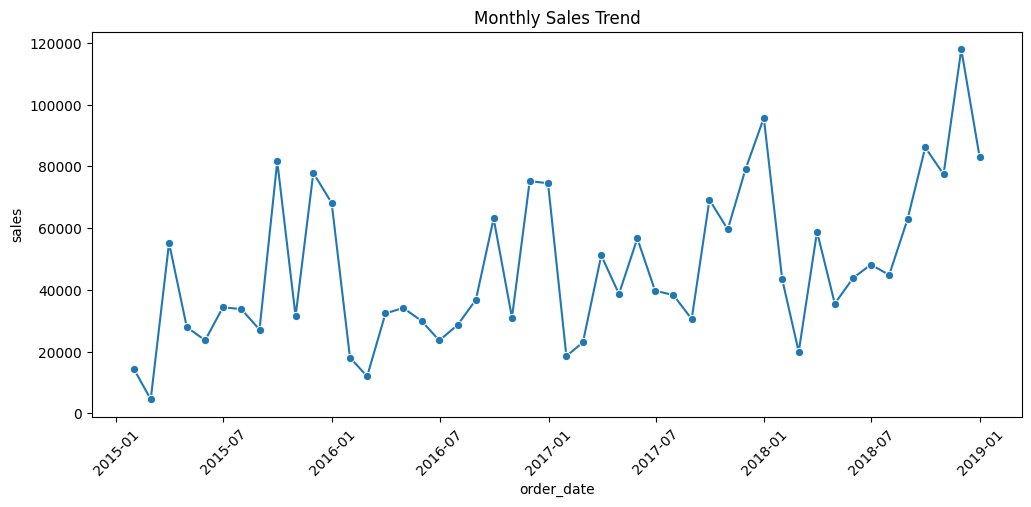

In [26]:
# Monthly Sales Trend
monthly_sales = df_original.groupby(pd.Grouper(key="order_date", freq="M"))['sales'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_sales, x="order_date", y="sales", marker="o")
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.show()

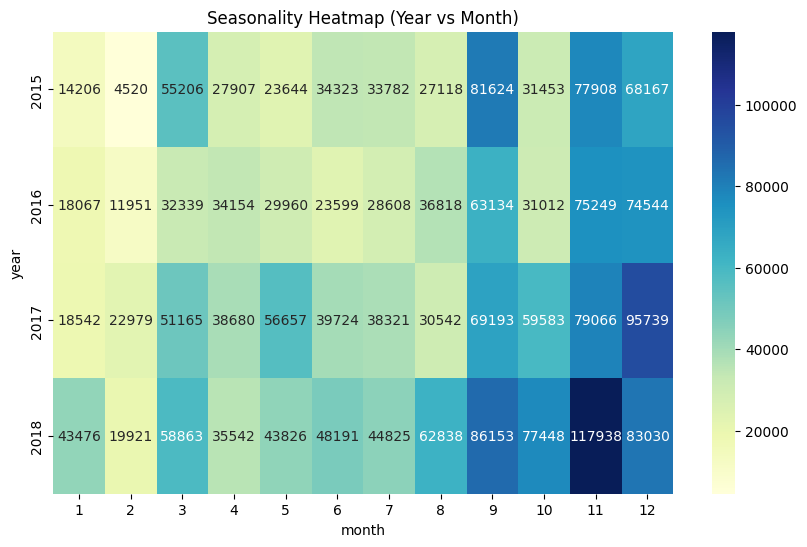

In [27]:
# Seasonality Heatmap (Year vs Month)
pivot = df_original.pivot_table(index="year", columns="month", values="sales", aggfunc="sum")
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Seasonality Heatmap (Year vs Month)")
plt.show()

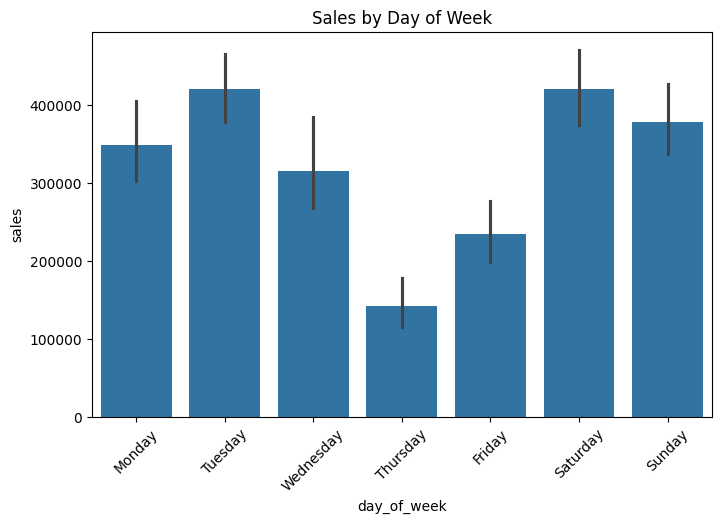

In [28]:
# Sales by Day of Week
plt.figure(figsize=(8,5))
sns.barplot(data=df_original, x="day_of_week", y="sales", estimator="sum", order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Sales by Day of Week")
plt.xticks(rotation=45)
plt.show()

In [29]:
# Sales by Region
fig = px.bar(df_original.groupby("region")['sales'].sum().reset_index(),
             x="region", y="sales", title="Sales by Region", color="region")
fig.show()

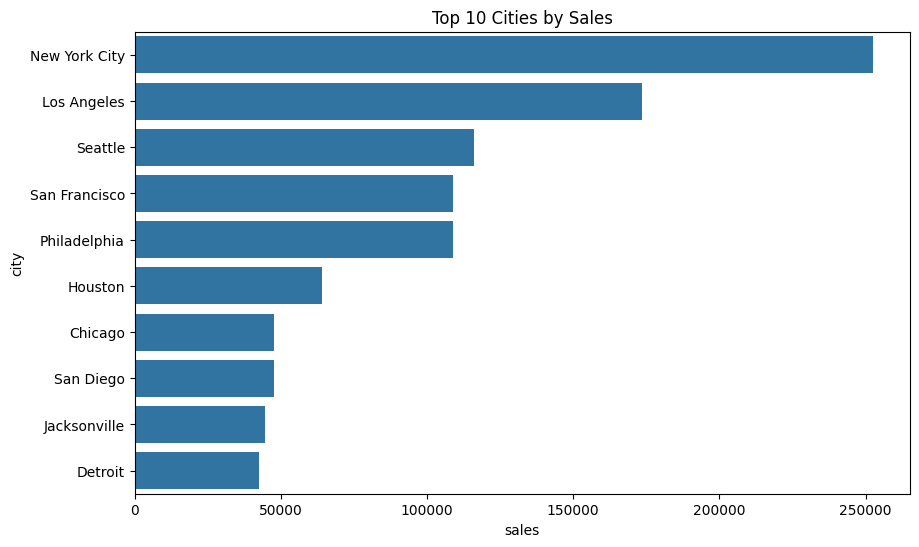

In [30]:
# Top 10 Cities by Sales
top_cities = df_original.groupby("city")['sales'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_cities, x="sales", y="city")
plt.title("Top 10 Cities by Sales")
plt.show()

In [31]:
# Sales by Segment
fig = px.pie(df_original, names="segment", values="sales", title="Sales by Customer Segment")
fig.show()

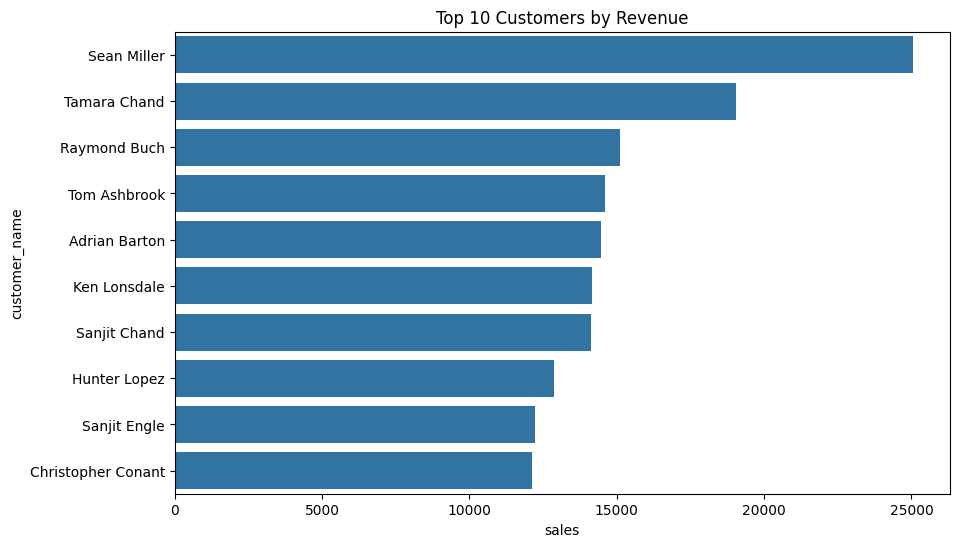

In [32]:
# Top 10 Customers by Sales
top_customers = df_original.groupby("customer_name")['sales'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_customers, x="sales", y="customer_name")
plt.title("Top 10 Customers by Revenue")
plt.show()

In [33]:
# Category and Sub-Category Contribution
fig = px.treemap(df_original, path=['category','sub-category'], values='sales',
                 title="Sales Contribution by Category & Sub-Category")
fig.show()

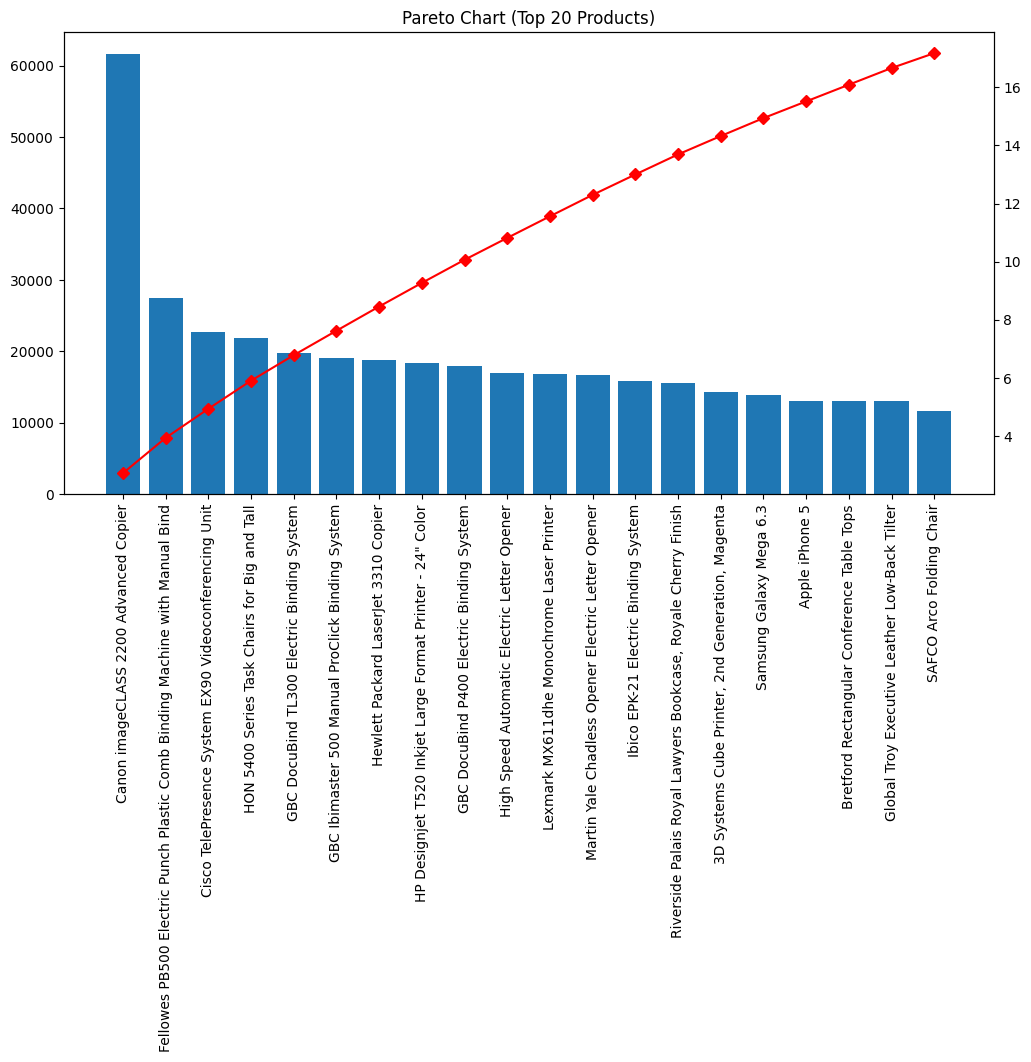

In [34]:
# Pareto Chart (Top Products)
product_sales = df_original.groupby("product_name")['sales'].sum().sort_values(ascending=False).reset_index()
product_sales['cumperc'] = product_sales['sales'].cumsum()/product_sales['sales'].sum()*100
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.bar(product_sales['product_name'][:20], product_sales['sales'][:20])
ax2 = ax1.twinx()
ax2.plot(product_sales['product_name'][:20], product_sales['cumperc'][:20], color="red", marker="D")
ax1.set_title("Pareto Chart (Top 20 Products)")
ax1.set_xticklabels(product_sales['product_name'][:20], rotation=90)
plt.show()

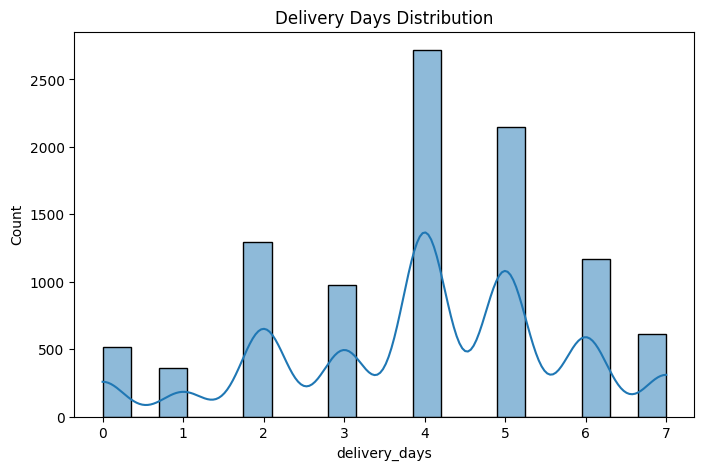

In [35]:
# Delivery Days Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_original['delivery_days'], bins=20, kde=True)
plt.title("Delivery Days Distribution")
plt.show()

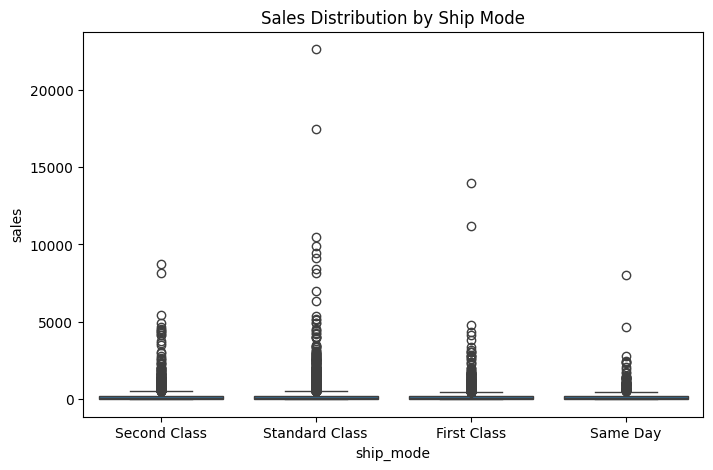

In [36]:
# Ship Mode vs Sales
plt.figure(figsize=(8,5))
sns.boxplot(data=df_original, x="ship_mode", y="sales")
plt.title("Sales Distribution by Ship Mode")
plt.show()

In [38]:
# Forecasting Visualizations for monthly sales time series
monthly_sales = df_original.groupby(pd.Grouper(key="order_date", freq="M"))['sales'].sum()
ts = monthly_sales.resample('MS').sum().fillna(method='ffill').fillna(method='bfill')

# Train/Test Split (last 12 months as test)
h = 12
train, test = ts[:-h], ts[-h:]

# Baseline Forecast: Naïve (last value)
naive_forecast = np.repeat(train.iloc[-1], h)

# Auto ARIMA Forecast
arima_model = pm.auto_arima(train, seasonal=True, m=12, trace=True,
                            error_action="ignore", suppress_warnings=True)
arima_forecast, conf_int = arima_model.predict(n_periods=h, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=824.086, Time=1.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=828.436, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=822.416, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=821.290, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=880.891, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=828.310, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=822.867, Time=0.52 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=820.150, Time=0.27 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=822.098, Time=0.30 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=820.077, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=821.190, Time=0.09 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=821.928, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=822.550, Time=0.15 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=819.738, Time=0.40 sec
 ARIMA(1,0,0)(0,0,1)[12] intercep

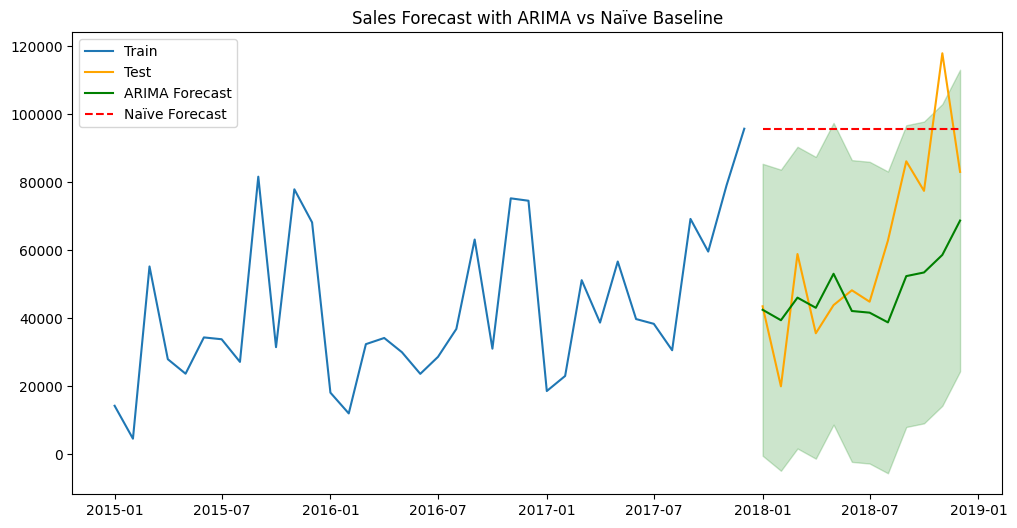

In [40]:
# Plot Sales Forecast with ARIMA vs Naïve Baseline
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="green")
plt.fill_between(test.index, conf_int[:,0], conf_int[:,1], color="green", alpha=0.2)
plt.plot(test.index, naive_forecast, label="Naïve Forecast", linestyle="--", color="red")
plt.title("Sales Forecast with ARIMA vs Naïve Baseline")
plt.legend()
plt.show()

In [45]:
# Error Metrics
print("Naive MAE:", mean_absolute_error(test, naive_forecast))
# Corrected: Calculate RMSE manually
print("Naive RMSE:", np.sqrt(mean_squared_error(test, naive_forecast)))
print("ARIMA MAE:", mean_absolute_error(test, arima_forecast))
# Corrected: Calculate RMSE manually
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_forecast)))

Naive MAE: 39267.958399999996
Naive RMSE: 43945.62352716607
ARIMA MAE: 17909.757122475716
ARIMA RMSE: 23731.971025636085


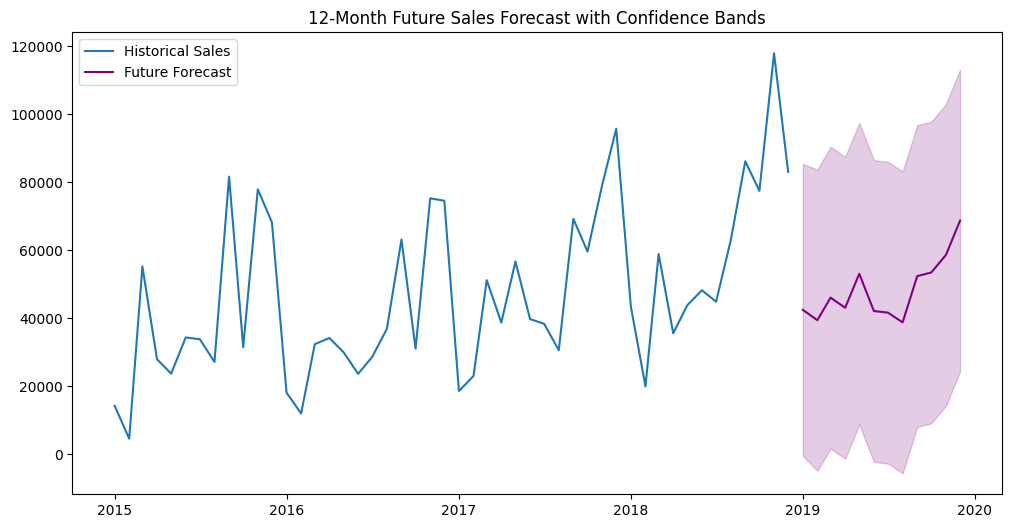

In [49]:
# Forecast Future 12 Months
future_forecast, conf_future = arima_model.predict(n_periods=12, return_conf_int=True)
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='MS')

# Plot 12-Month Future Sales Forecast with Confidence Bands
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts, label="Historical Sales")
plt.plot(future_index, future_forecast, label="Future Forecast", color="purple")
plt.fill_between(future_index, conf_future[:,0], conf_future[:,1], color="purple", alpha=0.2)
plt.title("12-Month Future Sales Forecast with Confidence Bands")
plt.legend()
plt.show()

In [50]:
# ML Forecasting (RF & GBR) vs ARIMA
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame({"y": series})
    for lag in range(1, lags+1):
        df_lags[f"lag_{lag}"] = series.shift(lag)
    return df_lags.dropna()

lags = 12
df_lags = create_lag_features(ts, lags=lags)

X = df_lags.drop("y", axis=1)
y = df_lags["y"]

# Train/Test split
X_train, X_test = X[:-h], X[-h:]
y_train, y[-h:]

# ---------------------------------
# Train ML Models
# ---------------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)

# Predictions
rf_preds = rf.predict(X_test)
gbr_preds = gbr.predict(X_test)

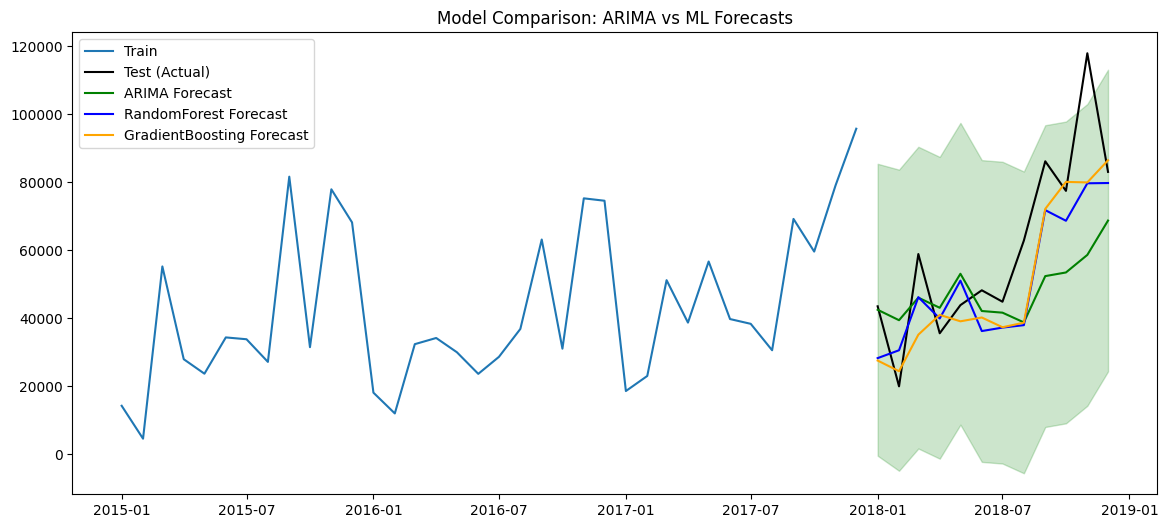

In [52]:
# Model Comparison
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test (Actual)", color="black")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="green")
plt.plot(test.index, rf_preds, label="RandomForest Forecast", color="blue")
plt.plot(test.index, gbr_preds, label="GradientBoosting Forecast", color="orange")
plt.fill_between(test.index, conf_int[:,0], conf_int[:,1], color="green", alpha=0.2)
plt.title("Model Comparison: ARIMA vs ML Forecasts")
plt.legend()
plt.show()

In [53]:
# Error Metrics Comparison
print("ARIMA MAE:", mean_absolute_error(test, arima_forecast))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_forecast)))
print("RF MAE:", mean_absolute_error(y_test, rf_preds))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("GBR MAE:", mean_absolute_error(y_test, gbr_preds))
print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, gbr_preds)))

ARIMA MAE: 17909.757122475716
ARIMA RMSE: 23731.971025636085
RF MAE: 13278.068616583381
RF RMSE: 16222.918640633327
GBR MAE: 12675.042247139325
GBR RMSE: 16467.89272193464


In [54]:
# Future Forecasting with ML
def iterative_forecast(model, series, lags, future_periods):
    history = series.copy()
    preds = []
    for _ in range(future_periods):
        # Corrected: Create features based on the list of lags
        feature_row = {}
        for lag in lags:
            if len(history) >= lag:
                 feature_row[f"lag_{lag}"] = history.iloc[-lag]
            else:
                 feature_row[f"lag_{lag}"] = np.nan # Handle cases with not enough history

        # Ensure the feature order matches the training data if model.feature_names_in_ is available
        X_new = pd.DataFrame([feature_row])
        if hasattr(model, 'feature_names_in_'):
            X_new = X_new.reindex(columns=model.feature_names_in_, fill_value=0)
        else:
            # Fallback: assumes column order is the same as X_train
            pass

        y_pred = model.predict(X_new)[0]
        preds.append(y_pred)
        history = pd.concat([history, pd.Series([y_pred], index=[history.index[-1] + pd.offsets.MonthBegin(1)])])
    return pd.Series(preds, index=pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(1), periods=future_periods, freq="MS"))

future_periods = 12
rf_future = iterative_forecast(rf, ts, lags=[1,2,3,6,12], future_periods=future_periods) # Pass lags as a list
gbr_future = iterative_forecast(gbr, ts, lags=[1,2,3,6,12], future_periods=future_periods) # Pass lags as a list

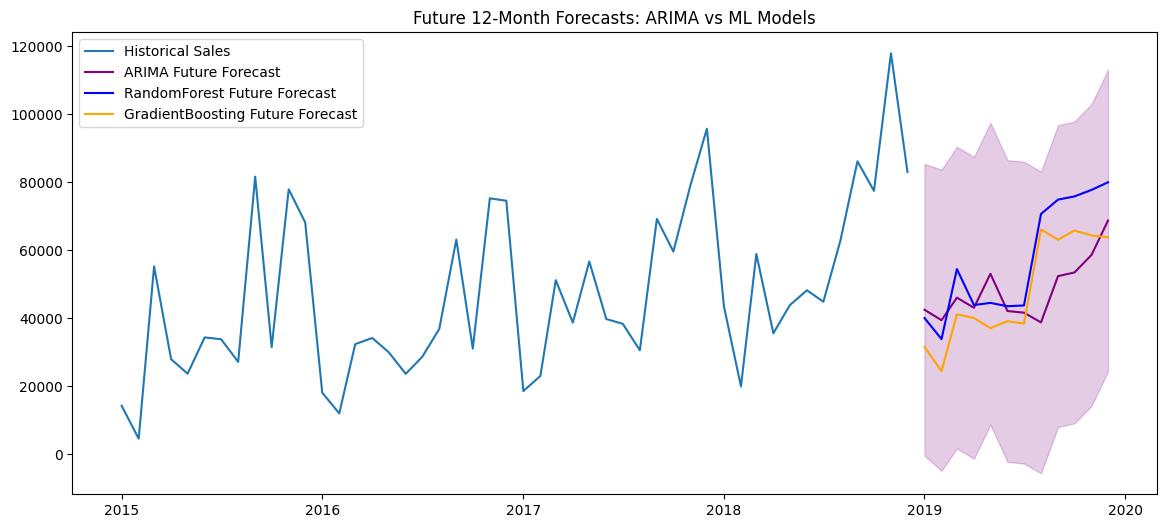

In [55]:
# Plot future forecasts
plt.figure(figsize=(14,6))
plt.plot(ts.index, ts, label="Historical Sales")
plt.plot(future_index, future_forecast, label="ARIMA Future Forecast", color="purple")
plt.plot(rf_future.index, rf_future, label="RandomForest Future Forecast", color="blue")
plt.plot(gbr_future.index, gbr_future, label="GradientBoosting Future Forecast", color="orange")
plt.fill_between(future_index, conf_future[:,0], conf_future[:,1], color="purple", alpha=0.2)
plt.title("Future 12-Month Forecasts: ARIMA vs ML Models")
plt.legend()
plt.show()

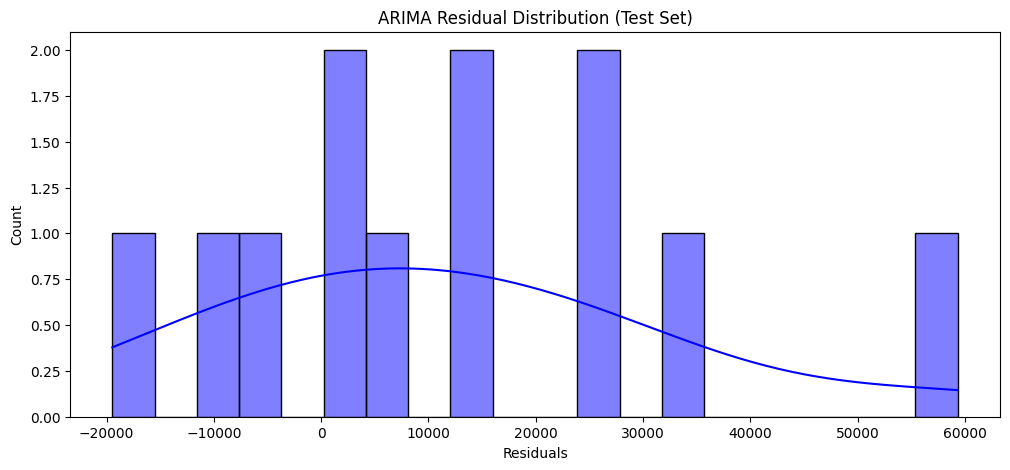

In [56]:
# Residual Diagnostics
# Residuals for ARIMA
arima_residuals = test - arima_forecast

plt.figure(figsize=(12,5))
sns.histplot(arima_residuals, bins=20, kde=True, color="blue")
plt.title("ARIMA Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.show()

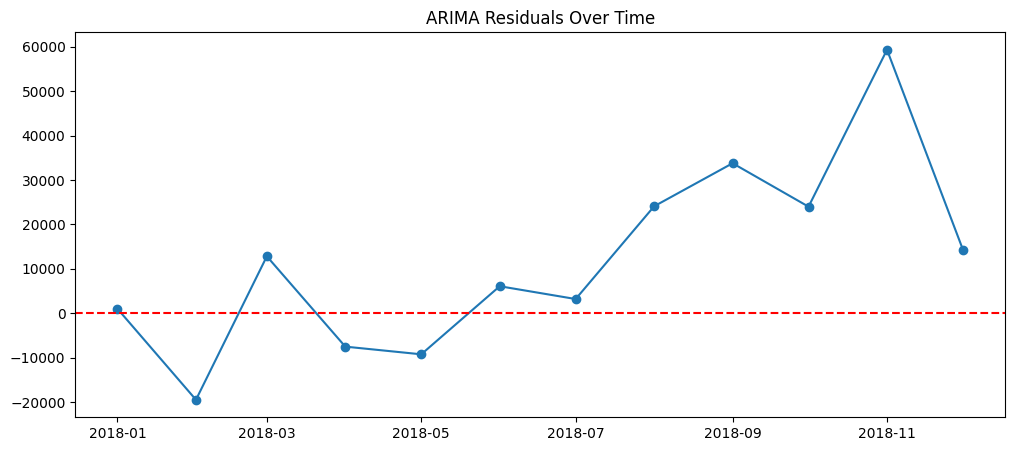

In [57]:
# Residuals over time
plt.figure(figsize=(12,5))
plt.plot(test.index, arima_residuals, marker="o")
plt.axhline(0, linestyle="--", color="red")
plt.title("ARIMA Residuals Over Time")
plt.show()

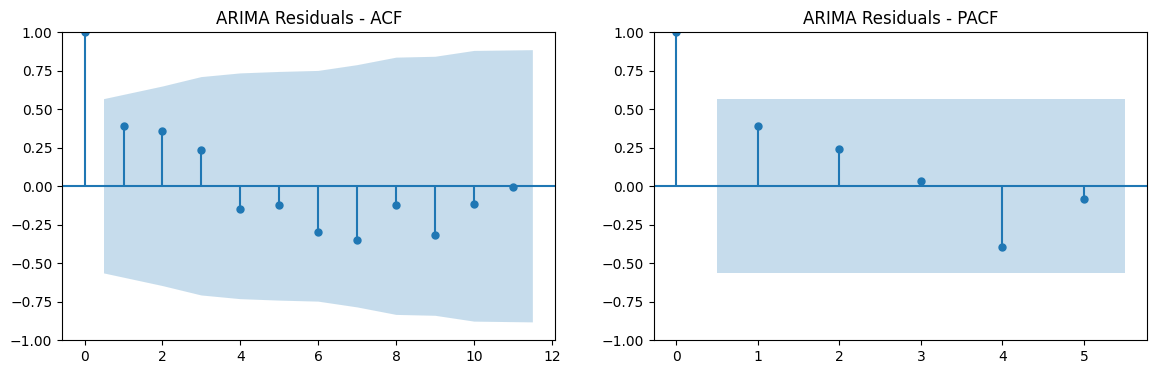

In [58]:
# Autocorrelation of residuals
fig, ax = plt.subplots(1,2, figsize=(14,4))
# Corrected: Reduce the number of lags for ACF and PACF plots
plot_acf(arima_residuals, ax=ax[0], lags=min(20, len(arima_residuals) - 1))
# Corrected: Further reduce the number of lags for PACF
plot_pacf(arima_residuals, ax=ax[1], lags=min(5, len(arima_residuals) // 2 - 1)) # Use max of 5 or half the sample size - 1
ax[0].set_title("ARIMA Residuals - ACF")
ax[1].set_title("ARIMA Residuals - PACF")
plt.show()

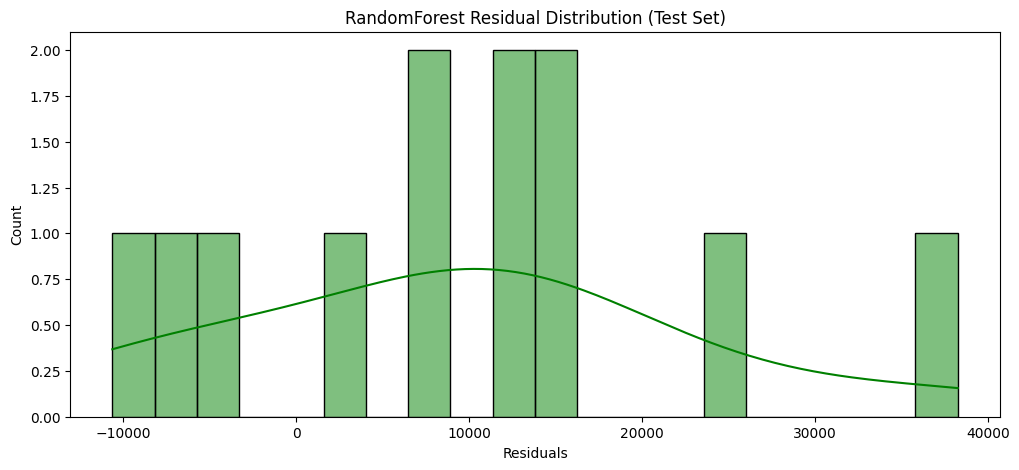

In [60]:
# Plot RandomForest Residual Distribution (Test Set)
rf_residuals = test - rf_preds

plt.figure(figsize=(12,5))
sns.histplot(rf_residuals, bins=20, kde=True, color="green")
plt.title("RandomForest Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.show()

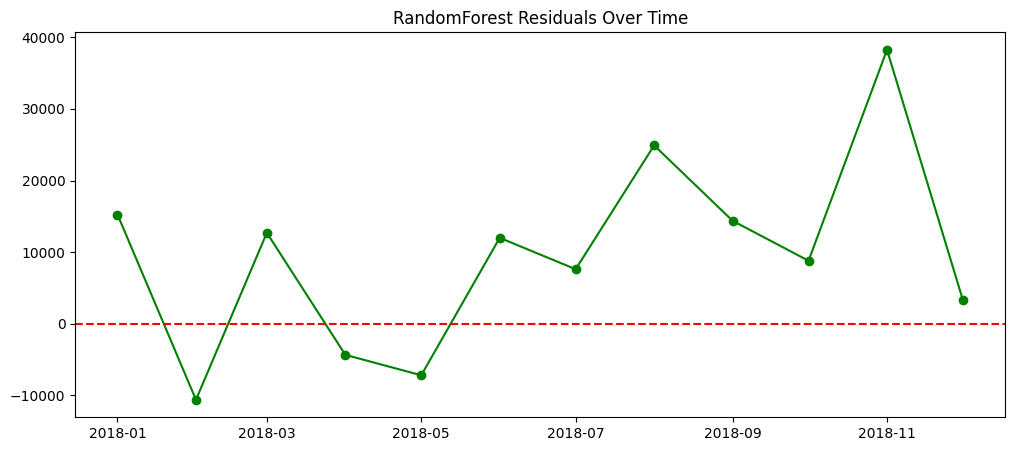

In [61]:
# Plot RandomForest Residuals Over Time
plt.figure(figsize=(12,5))
plt.plot(test.index, rf_residuals, marker="o", color="green")
plt.axhline(0, linestyle="--", color="red")
plt.title("RandomForest Residuals Over Time")
plt.show()

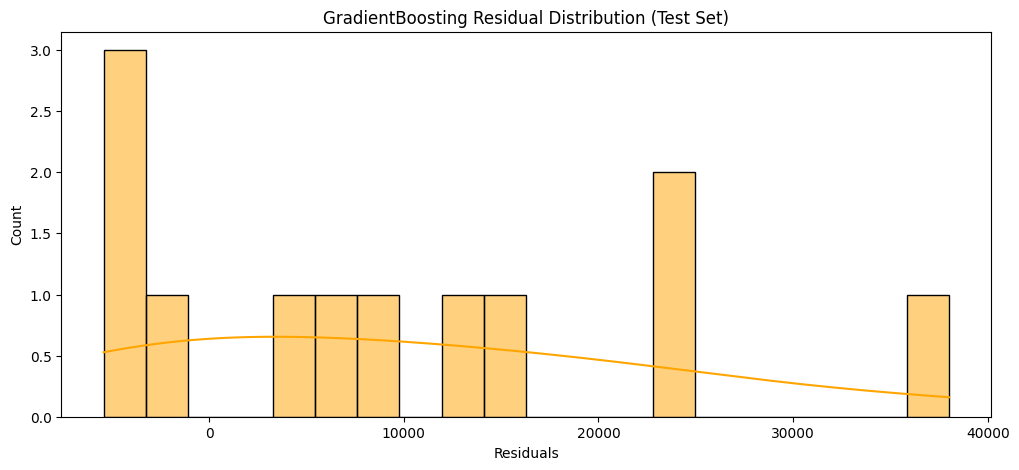

In [62]:
# Plot GradientBoosting Residual Distribution (Test Set)
gbr_residuals = test - gbr_preds

plt.figure(figsize=(12,5))
sns.histplot(gbr_residuals, bins=20, kde=True, color="orange")
plt.title("GradientBoosting Residual Distribution (Test Set)")
plt.xlabel("Residuals")
plt.show()

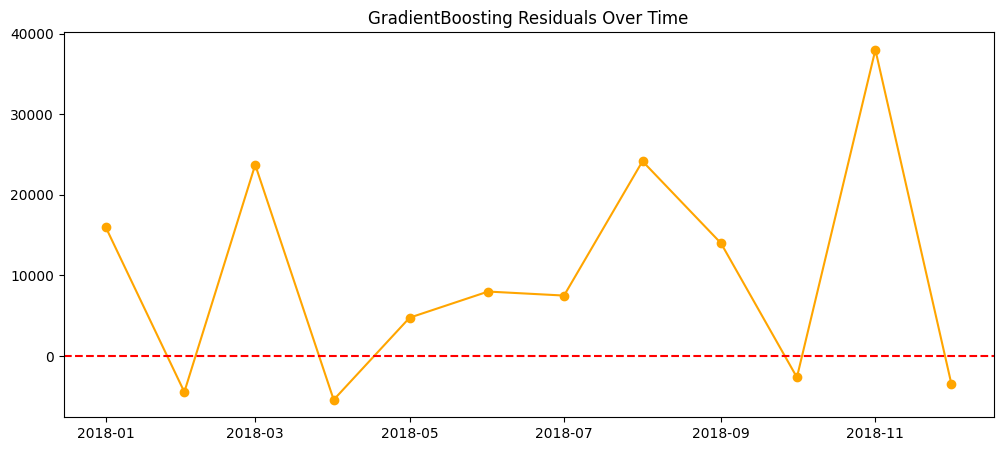

In [63]:
# Plot GradientBoosting Residuals Over Time
plt.figure(figsize=(12,5))
plt.plot(test.index, gbr_residuals, marker="o", color="orange")
plt.axhline(0, linestyle="--", color="red")
plt.title("GradientBoosting Residuals Over Time")
plt.show()